---

_This notebook was adapted and modified from a project for the course "Applied Machine Learning in Python" from the University of Michigan via Coursera. I discarded the provided test.csv data due to lack of our target feature._

---

## Understanding and Predicting Property Maintenance Fine Payments


[Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in.

All data for this assignment has been sourced from the [Detroit Open Data Portal](https://data.detroitmi.gov/).

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

Each row in the data corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing date, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.


<br>

**File descriptions** (Use only this data for training your model!)

    blight_data.csv - the training set (all tickets issued 2004-2011)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

blight_data.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


## Import libraries, then read in data and clean

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.cluster import KMeans
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix

#import warnings
#warnings.filterwarnings('ignore')


In [2]:
    #get the mapping of ticket_id to latitude, longitude
address = pd.read_csv('addresses.csv')
latlons = pd.read_csv('latlons.csv')
ticket_latlon = pd.merge(address, latlons, left_on='address', right_on='address')

    #import the data and merge to latlon data
blight_data = pd.read_csv('blight_data.csv', low_memory=False)
blight_data = pd.merge(blight_data, ticket_latlon, left_on='ticket_id',right_on='ticket_id')
blight_data = blight_data.set_index('ticket_id')

    # for this study, we will disregard the cases where the violator was found not responsible
blight_data = blight_data[np.isfinite(blight_data['compliance'])]

    #drop unimportant/null/redundant columns 
blight_data = blight_data.drop(['Unnamed: 0','violation_zip_code','non_us_str_code','violation_street_number','mailing_address_str_number','address','grafitti_status'], axis=1)

    #judgment_amount accounts for all fees and fines. remove all others
blight_data = blight_data.drop(['fine_amount','admin_fee','state_fee','late_fee','discount_amount','clean_up_cost'], axis=1)

    #data leakage alert: get rid of columns that have info we wouldn't have when we need to predict
blight_data = blight_data.drop(['compliance_detail','payment_date','payment_amount','balance_due','payment_status','collection_status'], axis=1)

blight_data.shape

(159880, 18)

In [3]:
    #check for any rows with at least 1 null (NaN)
nan_indices = blight_data[blight_data.isnull().any(axis=1)].index.values

    #drop these rows
blight_data.drop(nan_indices, inplace=True)

Upon brief inspection, the dates in many records don't make sense. For example, some records show the payment_date or hearing_date as earlier than the ticket_issued_date. I chose to remove these.

In [4]:
    #first check the data types of the columns. the dates should be in datetime format for easy comparisons
blight_data.dtypes

agency_name                  object
inspector_name               object
violator_name                object
violation_street_name        object
mailing_address_str_name     object
city                         object
state                        object
zip_code                     object
country                      object
ticket_issued_date           object
hearing_date                 object
violation_code               object
violation_description        object
disposition                  object
judgment_amount             float64
compliance                  float64
lat                         float64
lon                         float64
dtype: object

In [5]:
#we'll need to convert the date columns into a datetime format 
def time_to_hearing(myframe):
    myframe['ticket_issued_date'] = pd.to_datetime(myframe['ticket_issued_date'])
    myframe['hearing_date'] = pd.to_datetime(myframe['hearing_date'])   
    
        #neither of these timespans should be less than zero
    time_diff = myframe['hearing_date'] - myframe['ticket_issued_date']
    myframe['days_to_pay'] = time_diff.astype('timedelta64[D]')
    
time_to_hearing(blight_data)

    #let's keep only the records with good dates
blight_data = blight_data.loc[blight_data['days_to_pay'] >= 0]
blight_data.dtypes

agency_name                         object
inspector_name                      object
violator_name                       object
violation_street_name               object
mailing_address_str_name            object
city                                object
state                               object
zip_code                            object
country                             object
ticket_issued_date          datetime64[ns]
hearing_date                datetime64[ns]
violation_code                      object
violation_description               object
disposition                         object
judgment_amount                    float64
compliance                         float64
lat                                float64
lon                                float64
days_to_pay                        float64
dtype: object

### Split into train and test sets
It's good practice to split data into train and test sets at the very beginning of analysis. This simulates a production scenario where the model will need to make predictions on data it has never seen before. Even in the exploratory analysis, drawing conclusions from data that will be used in testing can lead to overfitting.

In [6]:
    #separate the target from the features
y_blight = blight_data['compliance']
X_blight = blight_data.drop('compliance', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_blight, y_blight, random_state=0)

    #combine the train sets for exploratory data analysis
blight_train = pd.merge(X_train, y_train.to_frame(), left_index=True, right_index=True)
blight_train.head()

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,judgment_amount,lat,lon,days_to_pay,compliance
ticket_id,,,,,,,,,,,,,,,,,,,
54108,"Buildings, Safety Engineering & Env Department","Legge, Gerald","BLADE, JAMES",SEVEN MILE,FORDHAM,DETROIT,MI,48205,USA,2005-10-25 13:30:00,2005-11-15 15:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Admission,280.0,42.434975,-82.992574,21.0,1.0
193607,Department of Public Works,"Hayes, Billy J","JOHNSON, BILLIE",SNOWDEN,SHAFTSBURY,DETROIT,MI,48219,USA,2008-10-09 10:00:00,2009-03-17 13:30:00,9-1-110(a),Inoperable motor vehicle(s) one- or two-family...,Responsible by Determination,85.0,42.396266,-83.176899,159.0,0.0
36698,"Buildings, Safety Engineering & Env Department","Keys, Edna","REED, GREEN",GRAND RIVER,KENTFIELD,DETROIT,MI,48235,USA,2005-06-09 10:15:00,2005-12-20 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,305.0,42.554454,-83.791406,194.0,0.0
82752,"Buildings, Safety Engineering & Env Department","Karwowski, Stephen","BENOIT, DOUGLAS",KILBOURNE,GRATIOT,DETROIT,MI,48205,USA,2006-07-06 10:35:00,2006-07-31 13:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,305.0,42.416153,-82.973969,25.0,0.0
276097,"Buildings, Safety Engineering & Env Department","Kent, Gerald","RHONE, TOMMIE",JAMES COUZENS,CHANDLER PARK DR,DETROIT,MI,48224,USA,2011-05-06 08:55:00,2011-06-21 09:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Admission,280.0,42.405527,-83.161665,46.0,1.0


## Analysis of Numerical Features

In [25]:
blight_train.describe()

,judgment_amount,lat,lon,days_to_pay,compliance
count,119593.000000,119593.000000,119593.000000,119593.000000,119593.000000
mean,420.117232,42.389737,-83.111649,72.760228,0.071175
std,746.134843,0.037300,0.093378,63.479775,0.257118
min,0.000000,42.145257,-84.096685,0.000000,0.000000
25%,250.000000,42.364531,-83.185882,31.000000,0.000000
50%,305.000000,42.392534,-83.124501,54.000000,0.000000
75%,305.000000,42.419159,-83.033555,100.000000,0.000000
max,11030.000000,44.785389,-82.512936,7933.000000,1.000000


### Does total fine + fee amount (judgment_amount) affect ticket compliance rates?
Let's look at the distributions of judgment_amount for tickets that were paid vs. unpaid

C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


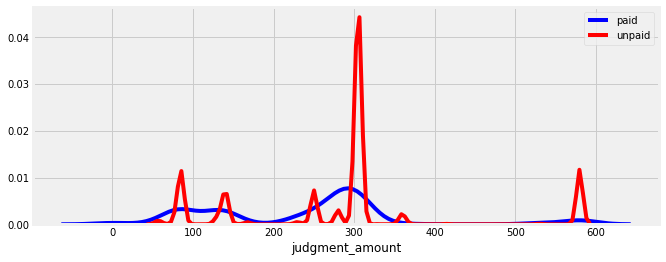

In [7]:
def plot_dists(my_frame, my_continuous_var):
        #separate our dataframe into two- one for each target class (paid, unpaid)
    com = my_frame.loc[my_frame['compliance'] == 1, my_continuous_var]
    non = my_frame.loc[my_frame['compliance'] == 0 , my_continuous_var]

        #ignore upperbound outliers for this visualization
    judgment925 = my_frame[my_continuous_var].quantile(.925)
    com = com.clip_upper(judgment925)
    non = non.clip_upper(judgment925)

        #plot the density distribution of data for each target class
    plt.figure(figsize = (10, 4))
    sns.distplot(com, color = 'blue', label = 'paid', hist=False)
    sns.distplot(non, color = 'red', label = 'unpaid', hist=False)
    plt.show()
    
    
plot_dists(blight_train, 'judgment_amount')


There is no clear divergence in the distributions, however the unpaid tickets seem to be grouped around a few different amounts whereas the paid tickets are more spread out.
Let's present the data with some different visuals

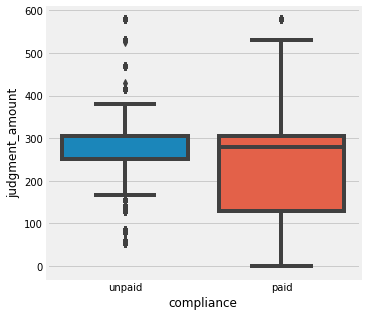

In [8]:
#boxplot

judgment925 = blight_train['judgment_amount'].quantile(.925)

plt.figure(figsize = (5, 5))
sns.boxplot(blight_train['compliance'], blight_train['judgment_amount'].clip_upper(judgment925))
plt.xticks([0,1],['unpaid','paid'])
plt.show()

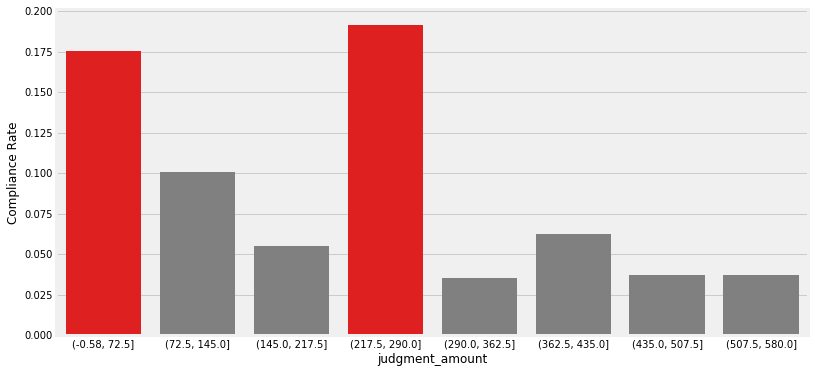

In [9]:
#bin judgment_amount, plot compliance rate

blight_train['judgment_binned'] = pd.cut(blight_train['judgment_amount'].clip_upper(judgment925), bins=8)
judg_bin = blight_train.groupby(['judgment_binned']).agg({'compliance': np.average})

plt.figure(figsize = (12, 6))
colors = ['grey' if (x < 0.15) else 'red' for x in judg_bin['compliance']]
sns.barplot(judg_bin.index, judg_bin['compliance'], palette=colors).set(xlabel='judgment_amount',ylabel='Compliance Rate')
plt.show()

It seems counter intuitive that larger fines (\$217.5 - 290.0) would be paid at a higher rate than smaller ones (\$72.5 - 145.0) and (\$145.0 - 217.5). Some other feature may be at play here that can help explain compliance.

### Does compliance vary by location of the property? 
Create heatmaps illustrating the geographical layout of compliance

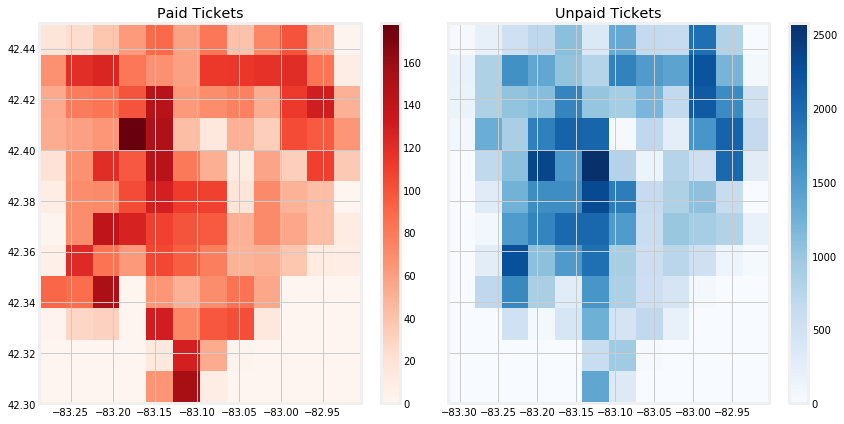

In [10]:
latlon = blight_train[['lat','lon','compliance']]

    # restrict that dimensions to focus on the main cluster of data
latlon = latlon.loc[(latlon['lat'] < 42.45) & (latlon['lat'] > 42.3)]
latlon = latlon.loc[(latlon['lon'] < -82.4) & (latlon['lon'] > -83.35)]

    #plot two different heatmaps; one plot would get too cluttered
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist2d('lon', 'lat', cmap='Reds', bins=12, data=latlon.loc[latlon['compliance'] == 1])
plt.colorbar()
plt.gca().set_title('Paid Tickets')

plt.subplot(1, 2, 2)
plt.hist2d('lon', 'lat', cmap='Blues', bins=12, data=latlon.loc[latlon['compliance'] == 0])
plt.colorbar()
fig2 = plt.gca()
fig2.set_title('Unpaid Tickets')
fig2.set_yticklabels([])
plt.tight_layout()


## Analysis and Feature Engineering with Categorical Features
### Let's get a look at the compliance rates by mailing address state
There are many levels of this categorical variable. Grouping these and reducing the number of levels will help our predictive model.

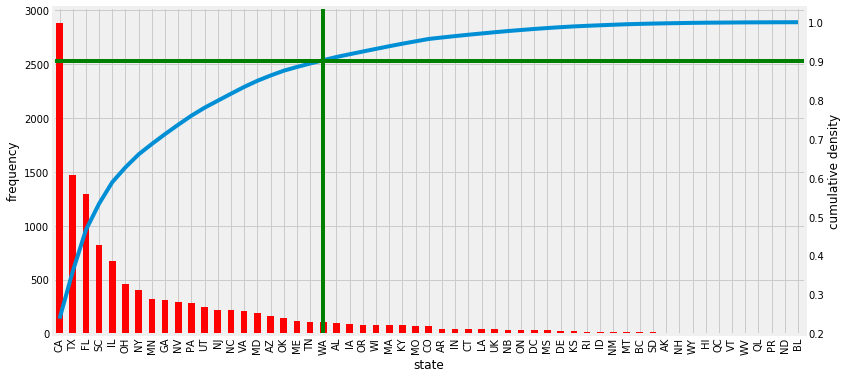

average      0.067308
count      104.000000
Name: WA, dtype: float64

In [11]:
    #first let's look at the states by record count, so we can relegate the low sample states to an "other" bucket
vis_compl_state = blight_train.groupby(['state']).agg({'compliance': [np.average, 'count']})
vis_compl_state.columns = vis_compl_state.columns.droplevel()
vis_compl_state = vis_compl_state.sort_values(by='count', ascending=False)

    #let's only look at the states excluding Michigan, since Michigan accounts for ~90% of records
other_states = vis_compl_state.loc[vis_compl_state.index != 'MI']

    #let's look at a cumulative density plot of the number of records for each state in order to determine a cutoff
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

other_states['count'].plot(kind='bar', color='red', ax=ax)
plt.ylabel('frequency')
cum_perc = other_states['count'].cumsum()/other_states['count'].sum()

plt.plot(other_states.index, cum_perc)
ax2.grid(False)

    #let's relegate the last 10% to an 'other' bucket (we do this in a future step). Cutoff visualized with green lines.
plt.axhline(y=0.9, color='green')
plt.axvline(x='WA', color='green')
ax.set_ylabel('frequency')
ax2.set_ylabel('cumulative density')
plt.show()

vis_compl_state.loc['WA']

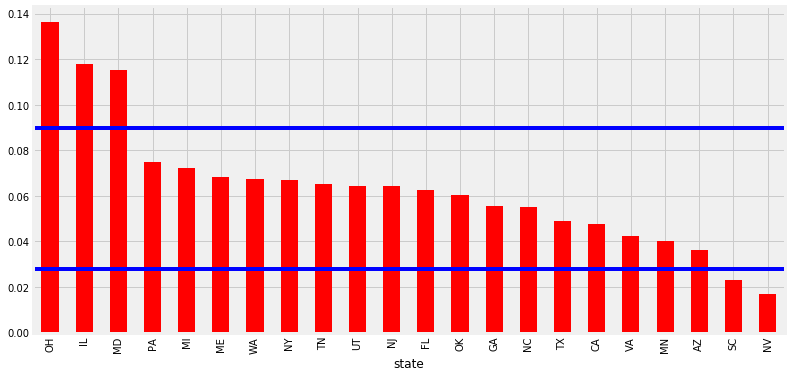

In [12]:
    #amongst the remaining states, we can group into three buckets by eyeballing the compliance rates
state_cutoff = vis_compl_state.loc[vis_compl_state['count'] >= 104]

plt.figure(figsize = (12, 6))
state_cutoff['average'].sort_values(ascending=False).plot(kind='bar', color='red')

plt.axhline(y=0.09, color='blue')
plt.axhline(y=0.028, color='blue')

plt.show()

In [13]:
    #low sample bucket
other = vis_compl_state.loc[vis_compl_state['count'] < 104].index.values.tolist()
    #high compliance bucket
high_comp = vis_compl_state.loc[(vis_compl_state['average'] > 0.09) & (vis_compl_state['count'] >= 104)].index.values.tolist()
    #mid compliance bucket
mid_comp = vis_compl_state.loc[(vis_compl_state['average'] < 0.09) & (vis_compl_state['average'] >= 0.028) &
                               (vis_compl_state['count'] >= 104)].index.values.tolist()    
    #low compliance bucket
low_comp = vis_compl_state.loc[(vis_compl_state['average'] < 0.028) & (vis_compl_state['count'] >= 104)].index.values.tolist()

    #create a mapping of states to their custom bucket name
state_bucket_names = ['other'] * len(other)
state_bucket_names += ['high_comp'] * len(high_comp)
state_bucket_names += ['mid_comp'] * len(mid_comp)
state_bucket_names += ['low_comp'] * len(low_comp)

state_list = other + high_comp + mid_comp + low_comp

state_mapping = dict(zip(state_list, state_bucket_names))

    #create a new column, assign all unseen states to 'other' bucket
blight_train['state_mapped'] = blight_train.state.map(state_mapping).fillna('other')

### Does the type of violation listed (violation_code) affect ticket compliance rates?
There are many unique codes in the data. Let's group these by the prefix.

In [14]:
#since we're engineering a new feature here, we'll want to make a function so we can easily apply it to the test data

def violation_cat(myframe):

        #There are many unique codes in the data. Let's group these by the prefixes
    patt22, patt9, patt61 = re.compile('22-2', re.IGNORECASE), re.compile('9-1', re.IGNORECASE), re.compile('61-', re.IGNORECASE)

        #create and apply the regex function that will map the codes to buckets
    def viol_map(text):
            if patt22.findall(text):
                return 'Code 22-2'
            elif patt9.findall(text):
                return 'Code 9-1'
            elif patt61.findall(text):
                return 'Code 61-'
            else:
                return 'Code Other'

    myframe['violation_cat'] = myframe['violation_code'].apply(viol_map)

violation_cat(blight_train)

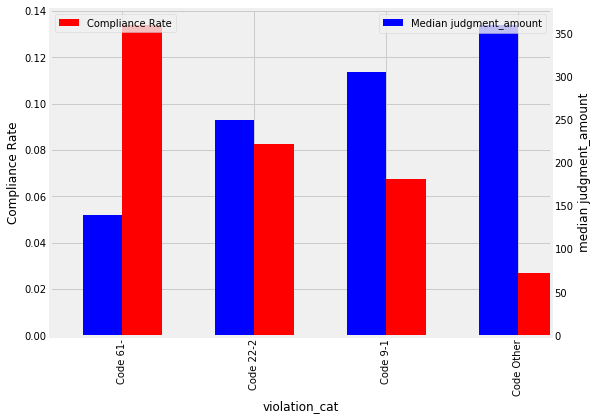

In [15]:
#let's visualize compliance by category. we'll compare judgment_amount as well.
    
    #aggregate compliance by our new violation buckets
viol_cat = blight_train.groupby(['violation_cat']).agg({'compliance': [np.average, np.sum, 'count']})
viol_cat.columns = viol_cat.columns.droplevel()
viol_cat.columns = ['rate', 'paid', 'total']

viol_price = blight_train.groupby(['violation_cat']).agg({'judgment_amount': [np.average, np.median]})
viol_price.columns = viol_price.columns.droplevel()

viol_plot = pd.merge(viol_price, viol_cat, left_index=True, right_index=True).sort_values(by=['median'])


    #compare rates in barplot
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

viol_plot['rate'].plot(kind='bar', color='red', ax=ax, width=0.3, position=0, label='Compliance Rate')
viol_plot['median'].plot(kind='bar', color='blue', ax=ax2, width=0.3, position=1, label='Median judgment_amount')

ax.set_ylabel('Compliance Rate')
ax2.set_ylabel('median judgment_amount')
ax2.grid(False)

ax.legend(loc=2)
ax2.legend(loc=1)

plt.show()

The rates are quite different for each violation type- this will be a useful feature for predicting compliance. In addition, we can see that the more expensive the violation type, the less likely the ticket will be paid.

### Let's do a similar analysis for the agency who issued the fine.

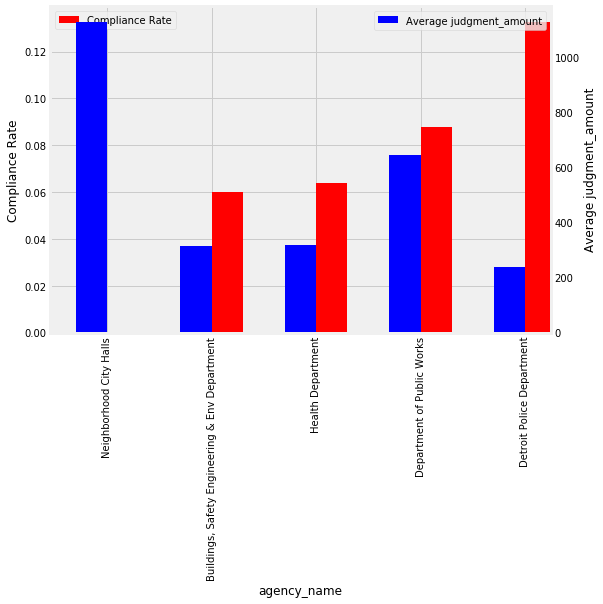

In [16]:
    #group by agency_name
agency_comp = blight_train.groupby(['agency_name']).agg({'compliance': [np.average]})
agency_judg = blight_train.groupby(['agency_name']).agg({'judgment_amount': [np.average]})

agency_plot = pd.merge(agency_comp, agency_judg, left_index=True, right_index=True)
agency_plot.columns = agency_plot.columns.droplevel()
agency_plot.columns = ['comp_avg', 'judg_avg']
agency_plot.sort_values(by=['comp_avg'], inplace=True)


    #compare rates in barplot
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

agency_plot['comp_avg'].plot(kind='bar', color='red', ax=ax, width=0.3, position=0, label='Compliance Rate')
agency_plot['judg_avg'].plot(kind='bar', color='blue', ax=ax2, width=0.3, position=1, label='Average judgment_amount')

ax.set_ylabel('Compliance Rate')
ax2.set_ylabel('Average judgment_amount')
ax2.grid(False)

ax.legend(loc=2)
ax2.legend(loc=1)
plt.show()

### Is the rate of fine compliance affected by type of violator? Company/organization vs. person/household

In [17]:
def violatorname_orgperson(myframe):
    
    myframe['violator_name'] = myframe['violator_name'].str.lower()

        #creating list of indicators of a company/organization. bare with me on some hardcoding
    comp_org_indicators = ['l.l.c.', 'llc', 'ltd', 'inc', 'apt', 'propert', 'bank', 'church', 'temple', 'michigan', 
                               'a/k/a', 'corp', 'detroit', 'market', 'salon', 'mart,' 'insurance', 'liquor',
                               'restaurant', 'company', 'chicken', 'enterprise', 'store', 'co.','shop','service',
                               'group','society', 'limited','capital', 'invest', 'federal', 'lounge', 'assoc', 
                               'clean', 'finance', 'apartment', 'mortgage', 'dept', 'realty', 'prayer', 
                               'supplies', 'estate', 'auto', 'center', 'management', 'pub', 'ministr', '&', '#', '\*']
    patterns = '|'.join(comp_org_indicators) 

        #create new column based on presence of 1 or more keyword
    myframe['violator_type'] = np.where(myframe['violator_name'].str.contains(patterns) , 'org', 'person')   
    
violatorname_orgperson(blight_train)

In [18]:
    #show compliance rate for orgs vs persons
vis_compl_viol = blight_train.groupby(['violator_type']).agg({'compliance': [np.average, np.sum, 'count']})
vis_compl_viol.columns = vis_compl_viol.columns.droplevel()
vis_compl_viol['default'] = vis_compl_viol[ 'count'] - vis_compl_viol['sum']
vis_compl_viol.columns = ['compliance rate', 'paid', 'total', 'default']
    
vis_compl_viol 


,compliance rate,paid,total,default
violator_type,,,,
org,0.072236,2613.0,36173,33560.0
person,0.070714,5899.0,83420,77521.0


In [19]:
   #perform a chi square test to compare proportions of paid/default across org/person    
vis_compl_viol = vis_compl_viol[['paid','default']].T
vis_prop_viol = np.array(vis_compl_viol[['org','person']])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(vis_prop_viol)
    
p_val

0.3534687192171545

We get a very large p-value, so we fail to reject the null hypothesis that the proportions are not different from each other. In other words, violator_type- whether person or organization- is not an informative feature for fine compliance.
### Let's look into days_to_pay: the number of days between the ticket issuance and hearing date.

C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


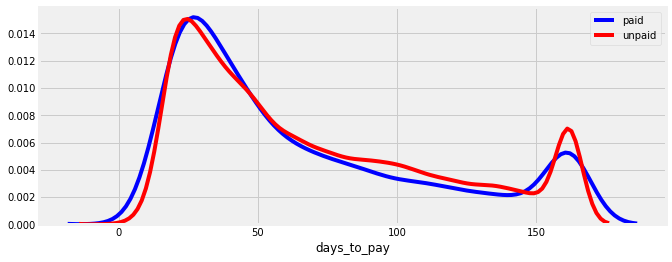

In [20]:
    #call the plot distribution function created earlier
plot_dists(blight_train, 'days_to_pay')

It looks like there may be some small differences in compliance depending on the number of days to pay.

Let's produce some multivariate visualizations.

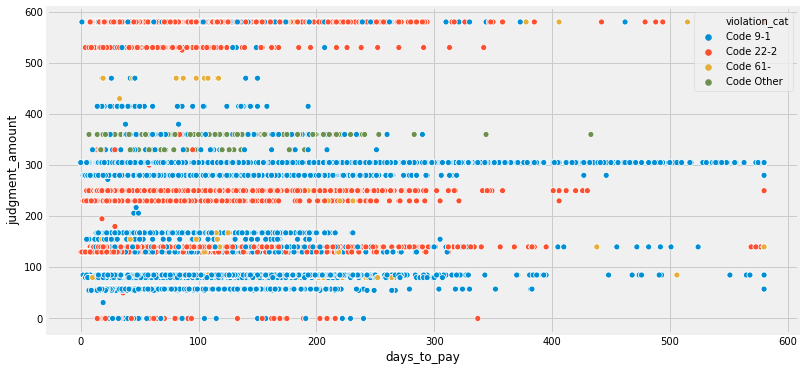

In [21]:
# investigating the relationship between judgment_amount, days_to_pay, and violation_cat

x = blight_train['days_to_pay'].clip_upper(judgment925)
y = blight_train['judgment_amount'].clip_upper(judgment925)

color_var = blight_train['violation_cat']

    #create a scatterplot with the violation_cat as the color code
plt.figure(figsize = (12, 6))
sns.scatterplot(x, y, hue=color_var)
plt.show()

It appears that certain judgment_amounts are exclusively made up of a single violation_cat.

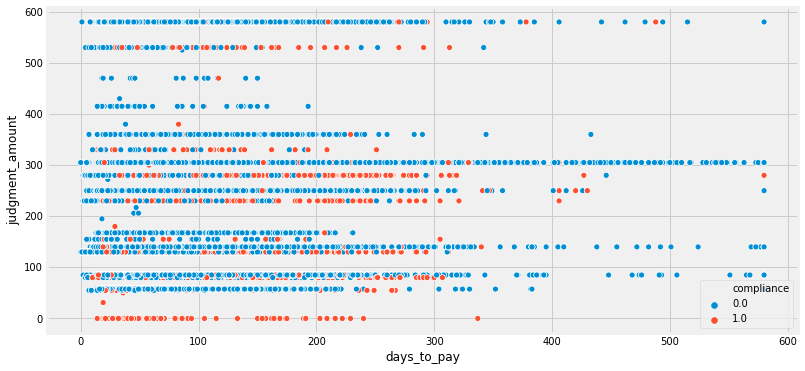

In [21]:
# investigating the relationship between judgment_amount, days_to_pay, and compliance

color_var2 = blight_train['compliance']

    #create a scatterplot with the compliance as the color code
plt.figure(figsize = (12, 6))
sns.scatterplot(x, y, hue=color_var2)
plt.show()


## Metric and Model Selection


In [50]:
    #view the number of instances of each class
np.bincount(blight_data.compliance.astype(int))

array([148047,  11411], dtype=int64)

Since the unpaid class represents ~93% of our data, accuracy is not the best metric to use here.
A simple dummy classifier that predicts every ticket as unpaid will have an accuracy of 93%.
<br /><br />
**Recall** is a measure of a classifier's ability to identify all positive instances in a dataset. The dummy classifier that predicts all 0's would have a 0% Recall score.
**Precision** is a measure of a classifier's ability to identify __only__ the positive instances as positive, and no more.
<br /><br />
While we should track both of these metrics, my intuition is that there is small penalty for incorrectly predicting that a ticket won't get paid. <br/> Therefore, __Recall__ will be the most important metric here.

In [21]:
    #narrowing down dataframe to just the important features and split back to X_train and y_train
X_train = blight_train[['agency_name','state_mapped','judgment_amount','lat','lon','days_to_pay','violation_cat']]
y_train = blight_train['compliance']

    #we also need to convert to dummy variables
X_train_dummy = pd.get_dummies(X_train, prefix=['agency_name','state_mapped','violation_cat'], 
                               columns=['agency_name','state_mapped','violation_cat'])


Since we performed some transformations and operations on the train data, we will need to do the same to the test data.

In [22]:
violation_cat(X_test)

X_test['state_mapped'] = X_test.state.map(state_mapping).fillna('other')


C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
    #narrowing down dataframe to just the important features
X_test = X_test[['agency_name','state_mapped','judgment_amount','lat','lon','days_to_pay','violation_cat']]

    #convert to dummy variables. Not to be confused with dummy classifier.
X_test_dummy = pd.get_dummies(X_test, prefix=['agency_name','state_mapped','violation_cat'], columns=['agency_name','state_mapped','violation_cat'])

    #add in missing dummy colummn since Neighborhood City Halls does not appear in test data
X_test_dummy['agency_name_Neighborhood City Halls'] = 0

Before choosing a model, we should consider the purpose of this exercise:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"**Understanding** and Predicting Property Maintenance Fine Payments"

Speed and efficiency is not an important factor here. It is important to **understand** which features play an imortant role in determining whether or not a fine will be paid. Making an incorrect prediction in this scenario is not very costly, so we should be willing to sacrifice some accuracy for more interpretability. 

The three classification algorithms I will test include, since they have both relatively high interpretability and performance:

- Dummy Classifier to establish a baseline accuracy
- Logistic regression
- Gradient boosted decision trees
- Naive Bayes

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

    #Dummy Classifier. Not to be confused with dummy variables.
    #Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_dummy_predictions = dummy_majority.predict(X_test)

    #confusion matrix
dummy_predicted = dummy_majority.predict(X_test)
dummy_confusion = confusion_matrix(y_test, dummy_predicted)
print(dummy_confusion, '\n')

#print(classification_report(y_test, dummy_predicted, target_names=['unpaid', 'paid']))
print('Accuracy: {:.4f}'.format(dummy_majority.score(X_test, y_test)))
print('Recall: {:.4f}'.format(recall_score(y_test, dummy_predicted)))
print('Precision: {:.4f}'.format(precision_score(y_test, dummy_predicted)))

[[36966     0]
 [ 2899     0]] 

Accuracy: 0.9273
Recall: 0.0000
Precision: 0.0000


C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
    #Logistic Regression
log_clf = LogisticRegression(C=1)
log_clf.fit(X_train_dummy, y_train)

    #confusion matrix
log_predicted = log_clf.predict(X_test_dummy)
log_confusion = confusion_matrix(y_test, log_predicted)
print(log_confusion, '\n')

print('Accuracy: {:.4f}'.format(log_clf.score(X_test_dummy, y_test)))
print('Recall: {:.4f}'.format(recall_score(y_test, log_predicted)))
print('Precision: {:.4f}'.format(precision_score(y_test, log_predicted)))

C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[36966     0]
 [ 2899     0]] 

Accuracy: 0.9273
Recall: 0.0000
Precision: 0.0000


C:\Users\jkohn\AppData\Local\Continuum\anaconda2\envs\p36workshop\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
    #Gradient Boosted Decision Tree
gbdt_clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 4, random_state = 0)
gbdt_clf.fit(X_train_dummy, y_train)

    #confusion matrix
gbdt_predicted = gbdt_clf.predict(X_test_dummy)
gbdt_confusion = confusion_matrix(y_test, gbdt_predicted)
print(gbdt_confusion, '\n')

print('Accuracy: {:.4f}'.format(gbdt_clf.score(X_test_dummy, y_test)))
print('Recall: {:.4f}'.format(recall_score(y_test, gbdt_predicted)))
print('Precision: {:.4f}'.format(precision_score(y_test, gbdt_predicted)))

[[36921    45]
 [ 2758   141]] 

Accuracy: 0.9297
Recall: 0.0486
Precision: 0.7581


In [27]:
    #Naive Bayes Classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_dummy, y_train)

    #confusion matrix
nb_predicted = nb_clf.predict(X_test_dummy)
nb_confusion = confusion_matrix(y_test, nb_predicted)
print(nb_confusion, '\n')

print('Accuracy: {:.4f}'.format(nb_clf.score(X_test_dummy, y_test)))
print('Recall: {:.4f}'.format(recall_score(y_test, nb_predicted)))
print('Precision: {:.4f}'.format(precision_score(y_test, nb_predicted)))

[[36009   957]
 [ 2831    68]] 

Accuracy: 0.9050
Recall: 0.0235
Precision: 0.0663


At this point, we can move forward with the Gradient Boosted Decision Tree since it has the best recall and precision scores.
We will need to do some tuning of this model; the learning rate and max_depth parameters control its complexity.

## Conclusion
After tinkering and tuning the parameters of the Gradient Boosting Classifier, I have come up with four models that sit on/near the outer boundary of the precision-recall and accuracy-recall curves.

- Model A: 64% accuracy, 53% recall, 10% precision
- Model B: 80% accuracy, 47% recall, 18% precision
- Model C: 87% accuracy, 38% recall, 24% precision
- Model D: 91% accuracy, 22% recall, 36% precision

The best model amongst these four will depend on the cost of False Positives and the opportunity cost of False Negatives. <br />
The cost of misclassifying a property owner who will not pay (no collection of payment) will determine our sensitivity to False Positives. <br />
The cost of following up on a property owner who was predicted to not pay but in reality was going to pay (employee labor hours wasted) will determine our sensitivity to False Negatives. <br /><br />

These costs would help determine which model is best for the purpose of predicting fine payments.

In [24]:
    # four optimal models
gbdt_A_clf = GradientBoostingClassifier(learning_rate = 4, max_depth = 7, random_state = 0)
gbdt_A_clf.fit(X_train_dummy, y_train)
    #confusion matrix
gbdt_A_predicted = gbdt_A_clf.predict(X_test_dummy)
gbdt_A_confusion = confusion_matrix(y_test, gbdt_A_predicted)
print('Model A \n', gbdt_A_confusion, '\n')

gbdt_B_clf = GradientBoostingClassifier(learning_rate = 2, max_depth = 3, random_state = 0)
gbdt_B_clf.fit(X_train_dummy, y_train)
    #confusion matrix
gbdt_B_predicted = gbdt_B_clf.predict(X_test_dummy)
gbdt_B_confusion = confusion_matrix(y_test, gbdt_B_predicted)
print('Model B \n', gbdt_B_confusion, '\n')

gbdt_C_clf = GradientBoostingClassifier(learning_rate = 2, max_depth = 5, random_state = 0)
gbdt_C_clf.fit(X_train_dummy, y_train)
    #confusion matrix
gbdt_C_predicted = gbdt_C_clf.predict(X_test_dummy)
gbdt_C_confusion = confusion_matrix(y_test, gbdt_C_predicted)
print('Model C \n', gbdt_C_confusion, '\n')

gbdt_D_clf = GradientBoostingClassifier(learning_rate = 2.62, max_depth = 2, random_state = 0)
gbdt_D_clf.fit(X_train_dummy, y_train)
    #confusion matrix
gbdt_D_predicted = gbdt_D_clf.predict(X_test_dummy)
gbdt_D_confusion = confusion_matrix(y_test, gbdt_D_predicted)
print('Model D \n', gbdt_D_confusion, '\n')


Model A 
 [[23839 13127]
 [ 1373  1526]] 

Model B 
 [[30721  6245]
 [ 1541  1358]] 

Model C 
 [[33423  3543]
 [ 1806  1093]] 

Model D 
 [[35811  1155]
 [ 2247   652]] 



## Feature Importance

Extracting the feature importance values from the classifiers, we can see which variables were most important to predicting fine compliance. Listed in order of decreasing importance, here are the top 5 for each model. <br />

Model A: &nbsp; judgment_amount, &nbsp; lat, &nbsp; days_to_pay, &nbsp; violation_cat_Code Other, &nbsp; lon <br />
Model B: &nbsp; judgment_amount, &nbsp; days_to_pay, &nbsp; lat, &nbsp; agency_name_Buildings..., &nbsp; lon <br />
Model C: &nbsp; judgment_amount, &nbsp; days_to_pay, &nbsp; lon, &nbsp; agency_name_Buildings..., &nbsp; lat <br />
Model D: &nbsp; judgment_amount, &nbsp; days_to_pay, &nbsp; lat <br />

Confirming intuition, the most important features across all models are judgment_amount and days_to_pay.

In [28]:
print(gbdt_A_clf.feature_importances_)
print(gbdt_B_clf.feature_importances_)
print(gbdt_C_clf.feature_importances_)
print(gbdt_D_clf.feature_importances_)

[6.30364739e-01 1.45499386e-01 2.23466414e-02 1.16726196e-01
 3.17847219e-05 1.18239145e-04 2.41926489e-04 1.69068145e-03
 0.00000000e+00 1.12365948e-02 0.00000000e+00 3.09289278e-05
 6.55519003e-05 2.19433846e-02 7.33002927e-03 2.51831137e-04
 4.21220860e-02]
[9.99446986e-01 1.00755435e-04 1.01038377e-05 4.23519195e-04
 1.65830299e-05 0.00000000e+00 0.00000000e+00 2.05247736e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[7.05990047e-01 4.14380144e-03 1.21742384e-01 1.55686016e-01
 6.80240366e-03 1.75815230e-05 6.75557146e-06 1.76645956e-04
 0.00000000e+00 4.01821745e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.06781791e-03 1.08004144e-04 2.61171538e-03
 2.45005297e-04]
[9.92094694e-01 1.95348176e-05 0.00000000e+00 7.88577159e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0

## Further Analysis

A few things I decided not to investigate during this analysis for sake of time and simplicity:
- categorizing disposition into buckets
- investigating the individual fines and fees instead of the total judgment_amount
- several other features that I ruled out as intuitively unimportant, such as street number and street name
- adjust any of the other parameters in the Gradient Boosting classifier

## Appendix:

In [ ]:
    #instead of categorizing the violation category, categorize the disposition
disp_mapping = {'Responsible by Default': 1, 'Responsible by Determination': 2, 'Responsible by Admission': 3,
                   'Responsible (Fine Waived) by Deter': 2, 'Responsible (Fine Waived) by Admis': 3, 
                   'Responsible - Compl/Adj by Default': 1, 'Responsible - Compl/Adj by Determi': 2,
                   'Responsible by Dismissal': 1}
    
blight_data = blight_data.replace({'disposition': disp_mapping})
    
blight_data = pd.get_dummies(blight_data, prefix=['disposition','state_binary'], columns=['disposition','state_binary'])
   

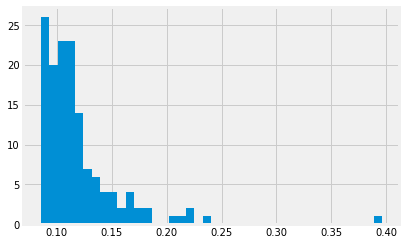

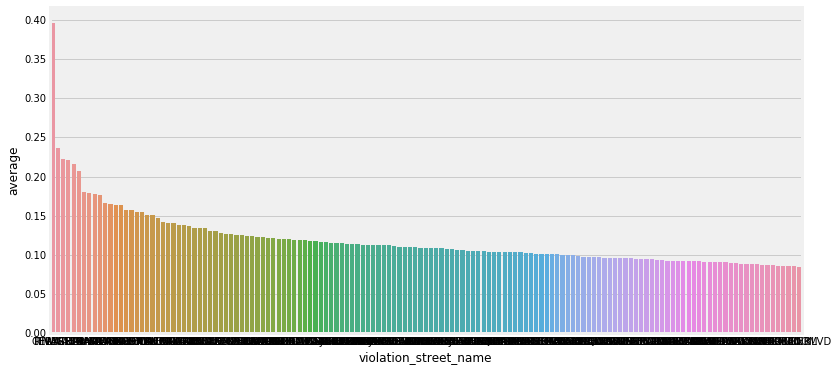

In [138]:
    #let's get a look at the compliance rates by violation street
vis_compl_street = blight_train.groupby(['violation_street_name']).agg({'compliance': [np.average, np.sum, 'count']})
vis_compl_street.columns = vis_compl_street.columns.droplevel()

x = vis_compl_street.sort_values(by='average', ascending=False).iloc[:500]
x = x.loc[x['count'] > 50]


plt.hist(x['average'], bins= 40)
plt.show()

plt.figure(figsize = (12, 6))
sns.barplot(x.index, x['average'])
plt.show() 
